## Face detection using Viola-Jones algorithm (open-cv)

In [1]:
import cv2
from skimage.io import imread
from skimage.color import rgb2gray
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

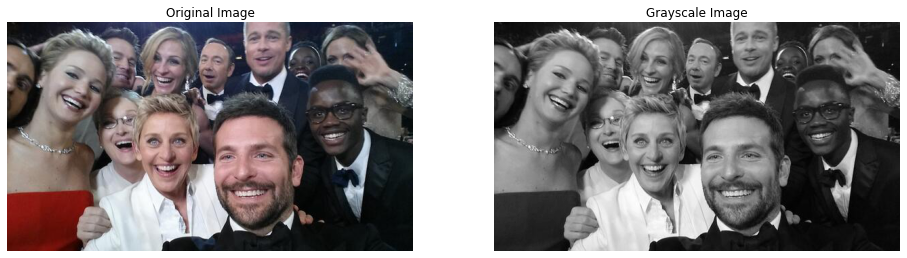

In [2]:
im = imread('./data/degeneres.jpg') # open image
im_gray = (rgb2gray(im) * 255).astype(np.uint8) # rgb2gray is [0,1] we need to go to [0,255]


fig, axes = plt.subplots(1, 2, figsize=(16, 10))
axes[0].imshow(im)
axes[0].set_title('Original Image')
axes[0].axis('off')
axes[1].imshow(im_gray, cmap='gray')
axes[1].set_title('Grayscale Image')
axes[1].axis('off')
plt.show()

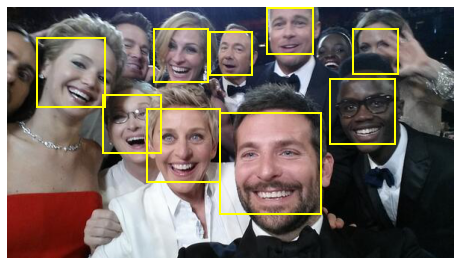

In [3]:
detector = cv2.CascadeClassifier('./data/haarcascade_frontalface_alt.xml') # Pretrained model
detected_faces = detector.detectMultiScale(im_gray, scaleFactor=1.1,
        minNeighbors=2,
        minSize=(40, 40),
        flags=cv2.CASCADE_SCALE_IMAGE) # detection


fig, ax = plt.subplots(figsize=(8, 10))
ax.imshow(im)
for (x, y, w, h) in detected_faces:
    ax.add_artist(Rectangle((x, y), w, h, fill=False, lw=2, color='yellow'))
    ax.set_axis_off()
plt.show()

### Smile classifier

In [4]:
import os

import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
import tensorflow.keras.backend as K

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D, Add, Dense, Flatten
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical

import numpy as np

import _pickle as cPickle
import bz2

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from skimage.transform import resize

In [5]:
def decompress_pickle(filename):
    data = bz2.BZ2File(filename, 'rb')
    data = cPickle.load(data)
    return data

def network_model(input_shape=(64, 64, 1)):
    input_img = Input(shape=input_shape)  # adapt this if using `channels_first` image data format
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
    mp1 = MaxPooling2D((2, 2), padding='same')(conv1)
    conv2 = Conv2D(8, (3, 3), activation='relu', padding='same')(mp1)
    mp2 = MaxPooling2D((2, 2), padding='same')(conv2)
    conv3 = Conv2D(8, (3, 3), activation='relu', padding='same')(mp2)
    mp3 = MaxPooling2D((2, 2), padding='same')(conv3)

    conv4 = Conv2D(8, (3, 3), activation='relu', padding='same')(mp3)
    up1 = UpSampling2D((2, 2))(conv4)
    add1 = Add()([conv3, up1])
    conv5 = Conv2D(8, (3, 3), activation='relu', padding='same')(add1)
    up2 = UpSampling2D((2, 2))(conv5)
    add2 = Add()([conv2, up2])
    conv6 = Conv2D(16, (3, 3), activation='relu', padding='same')(add2)
    up3 = UpSampling2D((2, 2))(conv6)
    add3 = Add()([conv1, up3])
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(add3)
    flatten = Flatten()(conv7)
    output = Dense(2, activation='sigmoid')(flatten)
    
    network = Model(input_img, output)
    network.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    
    return network

In [6]:
model = network_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 16)   160         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 32, 32, 16)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 8)    1160        max_pooling2d[0][0]              
______________________________________________________________________________________________

In [8]:
(x_train, y_train), (x_test, y_test) = decompress_pickle('./data/smiling_dataset.cpickle')

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.expand_dims(x_train, axis=3)
x_test = np.expand_dims(x_test, axis=3)

y_train = to_categorical(y_train) # [0,1], [1,0]
y_test = to_categorical(y_test)

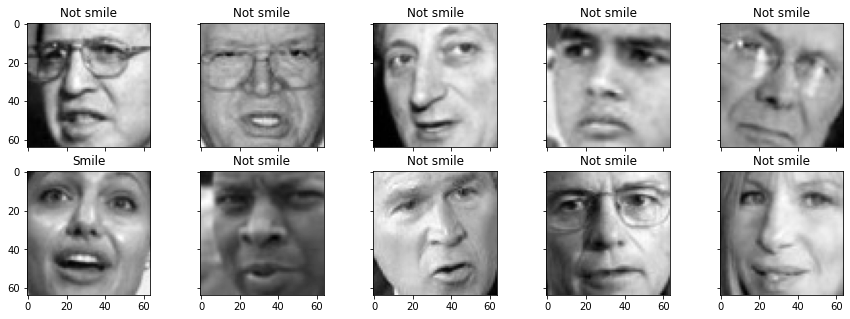

In [9]:
num_images = 10
labels = ['Not smile', 'Smile']
indexes = np.random.randint(0, x_train.shape[0], num_images) # Select N random images for testing


fig, axes = plt.subplots(int((num_images)/5 + 0.5), 5,
                       figsize=(15, 5), sharex='col', sharey='row')

for ax_idx, ax in enumerate(axes.flat):
    idx = indexes[ax_idx]
    im_train = x_train[idx]
    ax.imshow(np.squeeze(im_train), cmap='gray')
    ax.set_title("{}".format(labels[np.argmax(y_train[idx])]))
plt.show()

In [10]:
model_name = './data/smile_net.h5'

if not os.path.exists(model_name):
    model = network_model()
    model.fit(x_train, y_train, 
              epochs=100, 
              batch_size=16, 
              shuffle=True,
              validation_data=(x_test, y_test))

    model.save(model_name)
    
model = load_model(model_name)

Model accuracy in test set: 0.8943768996960486


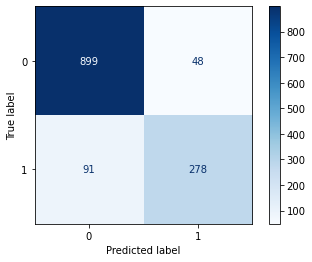

In [13]:
y_pred = model.predict(x_test)

accuracy_test = accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
print('Model accuracy in test set: {}'.format(accuracy_test))


cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
cm = ConfusionMatrixDisplay(cm)
cm.plot(values_format='d', cmap='Blues')
plt.show()

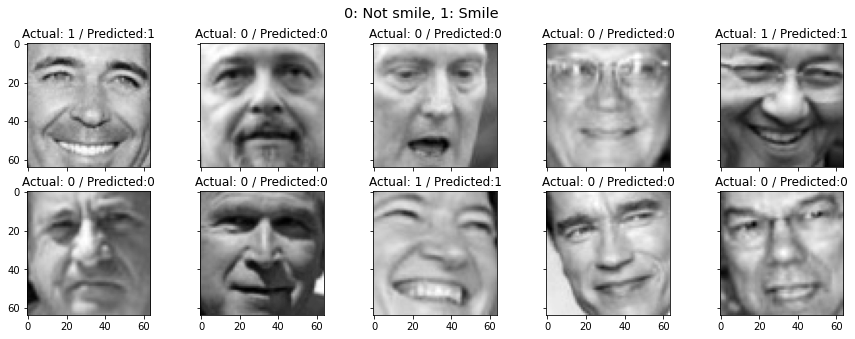

In [14]:
num_test_images = 10
indexes = np.random.randint(0, x_test.shape[0], num_test_images) # Select N random images for testing

fig, axes = plt.subplots(int((num_test_images)/5 + 0.5), 5,
                       figsize=(15, 5), sharex='col', sharey='row')

fig.suptitle('0: Not smile, 1: Smile', fontsize='x-large')
for ax_idx, ax in enumerate(axes.flat):
    idx = indexes[ax_idx]
    im_test = x_test[idx]
    y_hat = model.predict(np.expand_dims(im_test, axis=0))
    ax.imshow(np.squeeze(im_test), cmap='gray')
    ax.set_title("Actual: {} / Predicted:{}".format(np.argmax(y_test[idx]), np.argmax(y_hat)))
plt.show()

### Smile detection

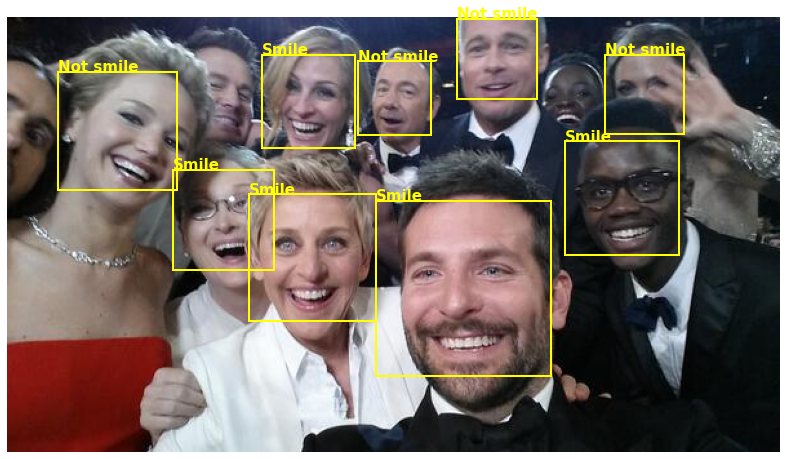

In [16]:
labels = ['Not smile', 'Smile']

im = imread('./data/degeneres.jpg') # open image
im_gray = (rgb2gray(im) * 255).astype(np.uint8) # rgb2gray is [0,1] we need to go to [0,255]

detector = cv2.CascadeClassifier('./data/haarcascade_frontalface_alt.xml') # Pretrained model
detected_faces = detector.detectMultiScale(im_gray, scaleFactor=1.1,
        minNeighbors=2,
        minSize=(40, 40),
        flags=cv2.CASCADE_SCALE_IMAGE) # detection

fig, ax = plt.subplots(figsize=(16, 8))
ax.imshow(im)
for (x, y, w, h) in detected_faces:
    face = im_gray[y:y+h, x:x+w]
    face = resize(face, (64, 64), anti_aliasing=True) # resize face to 64 x 64
    y_hat = model.predict(np.reshape(face, (1, 64, 64, 1)))
    #print(labels[np.argmax(y_hat)])
    #plt.imshow(face)
    ax.add_artist(Rectangle((x, y), w, h, fill=False, lw=2, color='yellow'))
    ax.annotate(labels[np.argmax(y_hat)], (x, y), color='yellow', weight='bold', 
                fontsize=15)
    ax.set_axis_off()
plt.show()

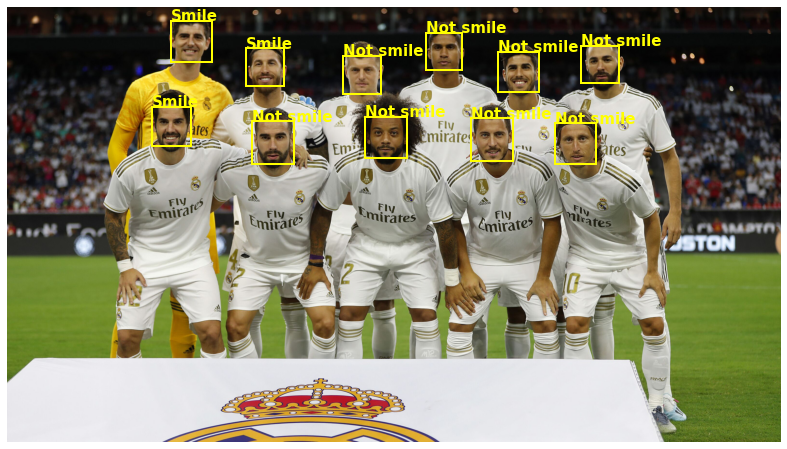

In [17]:
labels = ['Not smile', 'Smile']

im = imread('./data/real_madrid.jpeg') # open image
im_gray = (rgb2gray(im) * 255).astype(np.uint8) # rgb2gray is [0,1] we need to go to [0,255]

detector = cv2.CascadeClassifier('./data/haarcascade_frontalface_alt.xml') # Pretrained model
detected_faces = detector.detectMultiScale(im_gray, scaleFactor=1.1,
        minNeighbors=6,
        minSize=(50, 50),
        flags=cv2.CASCADE_SCALE_IMAGE) # detection

fig, ax = plt.subplots(figsize=(16, 8))
ax.imshow(im)
for (x, y, w, h) in detected_faces:
    face = im_gray[y:y+h, x:x+w]
    face = resize(face, (64, 64), anti_aliasing=True) # resize face to 64 x 64
    y_hat = model.predict(np.reshape(face, (1, 64, 64, 1)))
    #print(labels[np.argmax(y_hat)])
    #plt.imshow(face)
    ax.add_artist(Rectangle((x, y), w, h, fill=False, lw=2, color='yellow'))
    ax.annotate(labels[np.argmax(y_hat)], (x, y), color='yellow', weight='bold', 
                fontsize=15)
    ax.set_axis_off()
plt.show()